# Identifying handwritten mathematical symbols and letters
In this project I will be training a convolutonal neural network to recognize handwritten mathematical symbols and letters, and I will be using the HASYv2 dataset which has 168,000 images from 369 classes of symbols.

## Getting the data and performing data exploration

In [1]:
from IPython.display import Image
import csv
from PIL import Image as pil_image
from sklearn.model_selection import train_test_split
import keras.preprocessing.image
import numpy as np
import random

We'll take a quick look at an image, using the image class from PIL which allows us to open the image:

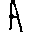

In [105]:
im = pil_image.open(r"/home/huginn/HASYv2/hasy-data/v2-00001.png")
display(im)

 They're 32x32 pixels images.

In [4]:
import pandas as pd

classes = pd.read_csv("/home/huginn/HASYv2/symbols.csv")
classes.head()

,symbol_id,latex,training_samples,test_samples
0,31,A,137,22
1,32,B,53,8
2,33,C,120,14
3,34,D,50,8
4,35,E,48,6


There is a `symbols.csv` file which contains the list of all 369 symbols, the number of samples available for each symbol.

In [10]:
classes.shape

(369, 4)

The `hasy-data-labels.csv` contains the path to all the images and their label: 

In [5]:
labels = pd.read_csv("/home/huginn/HASYv2/hasy-data-labels.csv")
labels.head()

,path,symbol_id,latex,user_id
0,hasy-data/v2-00000.png,31,A,50
1,hasy-data/v2-00001.png,31,A,10
2,hasy-data/v2-00002.png,31,A,43
3,hasy-data/v2-00003.png,31,A,43
4,hasy-data/v2-00004.png,31,A,4435


In [20]:
labels.shape

(168233, 4)

## Data preprocessing

Now we need to convert the images to numpy arrays to feed them to the neural network, and we'll also take a note of the class, we'll put them in a list `images` and `classes` respectively. We're also going to divide each pixel value in the array by 255 to rescale it to the range between 0 and 1 since neuron activation functions anct best with these values.

In [13]:
c = 0
images = []
classes = []
        
with open('/home/huginn/HASYv2/hasy-data-labels.csv') as csv_file:
    csv_reader = csv.reader(csv_file)
    for row in csv_reader:
        if c>0: #skipping the first row since it's the header
            
            img = keras.preprocessing.image.img_to_array(
                  pil_image.open("/home/huginn/HASYv2/" + row[0]))
            img /= 255.0
            images.append((row[2], img))
            classes.append(row[2])
        c += 1

Now we have a list with the numpy array version of the images and their string labels:

In [24]:
images[:1]

[('A',
  array([[[1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.],
          ...,
          [1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.]],
  
         [[1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.],
          ...,
          [1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.]],
  
         [[1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.],
          ...,
          [1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.]],
  
         ...,
  
         [[1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.],
          ...,
          [1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.]],
  
         [[1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.],
          ...,
          [1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.]],
  
         [[1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.],
          ...,
          [1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.]]], 

In [22]:
len(images)

168233

### Splitting the data
Here we'll split the data into 80% training and 20% testing sets after shuffling it, and then one-hot encode the labels.

In [14]:
random.shuffle(images)

input_full = np.asarray(list(map(lambda row: row[1], images)))
output_full_str = np.asarray(list(map(lambda row: row[0], images)))

split = int(len(input_full)*0.2)

train_input = input_full[split:]
test_input = input_full[:split]

train_output_str = output_full_str[split:]
test_output_str = output_full_str[:split]

In [39]:
len(train_output_str)

134587

### One-hot encoding the labels
We're going to use `sklearn.preprocessing`'s `LabelEncoder` and `OneHotEncoder`. First we convert the labels into integers using `LabelEncoder` and then convert them to one-hot encoding. 

In [40]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

label_encoder = LabelEncoder() 
onehot_encoder = OneHotEncoder(sparse=False)

int_encoded = label_encoder.fit_transform(classes)
int_encoded = int_encoded.reshape(len(int_encoded), 1)
onehot_encoder.fit(int_encoded)
             

train_output_int = label_encoder.transform(train_output_str)
train_output = onehot_encoder.transform(train_output_int.reshape(len(train_output_int), 1))

test_output_int = label_encoder.transform(test_output_str)
test_output = onehot_encoder.transform(test_output_int.reshape(len(test_output_int), 1))

# Training and evaluation the model
We're going to try first a classification multiple layer perceptron with 2 hidden layers. The first layer in the model, the Flatten layer, does some preliminary preprocessing by converting each input image to a 1D array, then we add 2 Dense hidden layers with 300 and 100 neurons each and with the `relu` activation function. Lastly we add a Dense output layer with 369 neurons which is the number of classes in the dataset, with the `softmax` activation function since the outputs are mutually exclusive, and assures that all the weights of the neurons add up to 1.

In [45]:
from keras.models import Sequential
from keras.layers import Dense, Flatten

model  = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[32, 32, 3]),
    keras.layers.Dense(300, activation='relu'),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(369, activation='softmax')
])

In [46]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 300)               921900    
_________________________________________________________________
dense_4 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_5 (Dense)              (None, 369)               37269     
Total params: 989,269
Trainable params: 989,269
Non-trainable params: 0
_________________________________________________________________


We then compile the model with the `categorical_crossentropy` since we have one target probability per class for each instance, and we'll use the `sgd` as the optimizer which performs simple Stochastic Gradient Descent, and finally we add `accuracy` as metrics to mesure the accuracy during training.

In [47]:
model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

We now fit the data to the model and use a 20% validation split, and perform 15 epochs.

In [48]:
history = model.fit(train_input, train_output, epochs=15, verbose=2, validation_split=0.2)

Epoch 1/15
3365/3365 - 20s - loss: 3.8633 - accuracy: 0.2740 - val_loss: 2.7009 - val_accuracy: 0.4280
Epoch 2/15
3365/3365 - 15s - loss: 2.2080 - accuracy: 0.5102 - val_loss: 2.0530 - val_accuracy: 0.5338
Epoch 3/15
3365/3365 - 15s - loss: 1.8053 - accuracy: 0.5801 - val_loss: 1.7002 - val_accuracy: 0.6003
Epoch 4/15
3365/3365 - 16s - loss: 1.5928 - accuracy: 0.6189 - val_loss: 1.5925 - val_accuracy: 0.6136
Epoch 5/15
3365/3365 - 15s - loss: 1.4523 - accuracy: 0.6452 - val_loss: 1.4888 - val_accuracy: 0.6371
Epoch 6/15
3365/3365 - 15s - loss: 1.3495 - accuracy: 0.6653 - val_loss: 1.4133 - val_accuracy: 0.6477
Epoch 7/15
3365/3365 - 15s - loss: 1.2669 - accuracy: 0.6804 - val_loss: 1.3484 - val_accuracy: 0.6581
Epoch 8/15
3365/3365 - 15s - loss: 1.2008 - accuracy: 0.6927 - val_loss: 1.3132 - val_accuracy: 0.6667
Epoch 9/15
3365/3365 - 15s - loss: 1.1445 - accuracy: 0.7045 - val_loss: 1.2838 - val_accuracy: 0.6735
Epoch 10/15
3365/3365 - 15s - loss: 1.0965 - accuracy: 0.7148 - val_loss:

We got around 70% accuracy which isn't too bad considering that there are 369 classes, but we'll try anothere network design to see if we can improve it.

Here we plot training and validation accuracy and loss, and we can see that the training curves are not too far from the validation curves so there isn't too much overfitting happening:

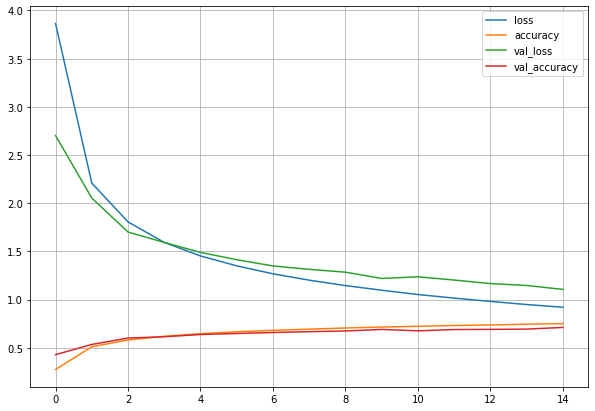

In [53]:
import matplotlib.pyplot as plt

pd.DataFrame(history.history).plot(figsize=(10, 7))
plt.grid(True)

We'll now try anothere network, and we'll add a convolution and dropout layer as well:

In [57]:
model2  = keras.models.Sequential([
    keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', 
                        input_shape=np.shape(train_input[0])),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(300, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(369, activation='softmax')
])

In [65]:
model2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 7200)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 300)               2160300   
_________________________________________________________________
dropout (Dropout)            (None, 300)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_8 (Dense)              (None, 369)              

In [59]:
model2.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
history2 = model2.fit(train_input, train_output, epochs=20, verbose=2, validation_split=0.2)

Epoch 1/20
3365/3365 - 67s - loss: 4.4948 - accuracy: 0.1766 - val_loss: 2.5267 - val_accuracy: 0.4779
Epoch 2/20
3365/3365 - 65s - loss: 2.1950 - accuracy: 0.5007 - val_loss: 1.4850 - val_accuracy: 0.6287
Epoch 3/20
3365/3365 - 64s - loss: 1.6143 - accuracy: 0.5976 - val_loss: 1.2113 - val_accuracy: 0.6787
Epoch 4/20
3365/3365 - 64s - loss: 1.3856 - accuracy: 0.6413 - val_loss: 1.0912 - val_accuracy: 0.7059
Epoch 5/20
3365/3365 - 64s - loss: 1.2523 - accuracy: 0.6687 - val_loss: 1.0168 - val_accuracy: 0.7276
Epoch 6/20
3365/3365 - 63s - loss: 1.1648 - accuracy: 0.6881 - val_loss: 0.9574 - val_accuracy: 0.7402
Epoch 7/20
3365/3365 - 73s - loss: 1.0967 - accuracy: 0.6995 - val_loss: 0.9224 - val_accuracy: 0.7425
Epoch 8/20
3365/3365 - 62s - loss: 1.0440 - accuracy: 0.7136 - val_loss: 0.8969 - val_accuracy: 0.7471
Epoch 9/20
3365/3365 - 62s - loss: 0.9998 - accuracy: 0.7220 - val_loss: 0.8626 - val_accuracy: 0.7602
Epoch 10/20
3365/3365 - 63s - loss: 0.9586 - accuracy: 0.7317 - val_loss:

(0.0, 1.5)

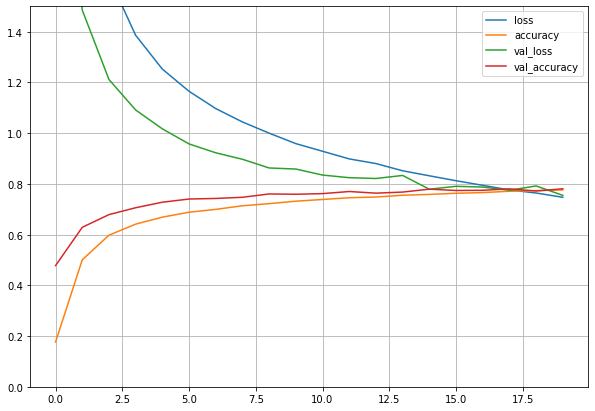

In [63]:
pd.DataFrame(history2.history).plot(figsize=(10, 7))
plt.grid(True)
plt.gca().set_ylim(0, 1.5)

This model didn't perform too badly and got a decent increase in accuracy, so we'll evaluate it on the test set to check the generalization error:

In [64]:
model2.evaluate(test_input, test_output)

1052/1052 [==============================] - 7s 7ms/step - loss: 0.7682 - accuracy: 0.7793


[0.7682269215583801, 0.779260516166687]

So in the end we got about 78% accuracy and now that we are satisfied with the performance and parameters we'll retrain the model using all the data to get the best model we can, and also save it, along with the `label_encoder` to reverse one-hot encoding to read the prediction results:

In [67]:
final_model = keras.models.Sequential([
    keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', 
                        input_shape=np.shape(train_input[0])),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(300, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(369, activation='softmax')])

final_model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
print(final_model.summary())
history_final = final_model.fit(np.concatenate((train_input, test_input)), 
                                np.concatenate((train_output, test_output)), 
                                epochs=20, verbose=2, validation_split=0.2)

final_model.save("symbols_model.model")
np.save("classes.npy", label_encoder.classes_)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 7200)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 300)               2160300   
_________________________________________________________________
dropout_1 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 100)               30100     
_________________________________________________________________
dense_11 (Dense)             (None, 369)              

(0.0, 2.0)

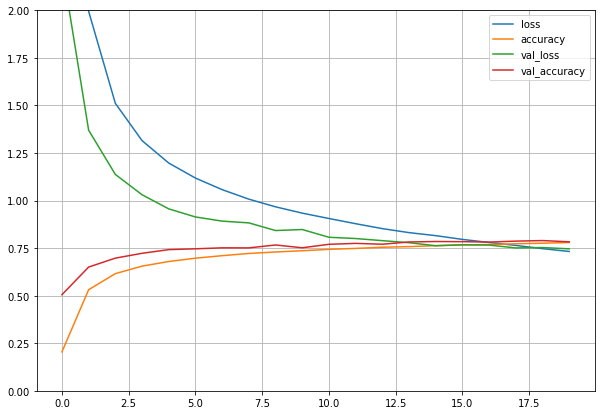

In [108]:
pd.DataFrame(history_final.history).plot(figsize=(10, 7))
plt.grid(True)
plt.gca().set_ylim(0, 2)

We'll have to write a prediction function that takes in an image path and converts that image to a numpy array and then scale the pixel values, and then also reverse the label encoding to get the string version of the label:

In [ ]:
 def predict(image_path):
        img = keras.preprocessing.image.img_to_array(pil_image.open(image_path))
        img /= 255.0
        
        prediction = final_model.predict(img.reshape(1, 32, 32, 3))
        
        inverted = label_encoder.inverse_transform([np.argmax(prediction)])
        
        print("Prediction: %s, confidence: %.2f" % (inverted[0], np.max(prediction)))

Now we can test the model on a few images, although they're from the training set because we don't have other ones. We'll load an image and then try to classify it:

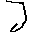

In [98]:
im1 = pil_image.open(r"/home/huginn/HASYv2/hasy-data/v2-00099.png")
display(im1)

In [97]:
predict("/home/huginn/HASYv2/hasy-data/v2-00099.png")

Prediction: J, confidence: 0.97


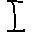

In [99]:
im2 = pil_image.open(r"/home/huginn/HASYv2/hasy-data/v2-00086.png")
display(im2)

In [100]:
predict("/home/huginn/HASYv2/hasy-data/v2-00086.png")

Prediction: I, confidence: 0.60


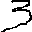

In [102]:
im3 = pil_image.open(r"/home/huginn/HASYv2/hasy-data/v2-00386.png")
display(im3)

In [103]:
predict("/home/huginn/HASYv2/hasy-data/v2-00386.png")

Prediction: 3, confidence: 0.91


# Summary
In this project I used a Sequential API to build, train and evaluate a classification MLP and used different libraries to process the images to prepare them for the neural network, and also one-hot encoded the labels to make it more optimal for the network. The model had a satisfactory performance with a 78% accuracy.